Process GOES/SUVI images

In [29]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunkit_instruments import suvi
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
import matplotlib.animation as animation

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

* 9.4 nm (FeXVIII)
* 13.1 nm (FeXXI)
* 17.1 nm (FeIX/X)
* 19.5 nm (FeXII)
* 28.4 nm (FeXV)
* 30.4 nm (HeII)

In [16]:
date = '2024-05-14'
YEAR, MONTH, DAY = date.split('-')
start_hour = '00'
start_minute = '00'
end_hour = '23'
end_minute = '59'
channel = 304

data_dir = '/home/mnedal/data'

In [17]:
# read the files names in order
if channel == 94:
    suvi_fits = sorted(glob.glob(f'{data_dir}/SUVI/{YEAR}{MONTH}{DAY}/{channel}A/*{channel}*g18*{YEAR}{MONTH}{DAY}*.fits'))
else:
    suvi_fits = sorted(glob.glob(f'{data_dir}/SUVI/{YEAR}{MONTH}{DAY}/{channel}A/*ci{channel}*g18*{YEAR}{MONTH}{DAY}*.fits'))

print(f'\nNumber of fetched SUVI files: {len(suvi_fits)}\n')


Number of fetched SUVI files: 360



In [18]:
1440/4

360.0

In [19]:
file = suvi_fits[263] # 263
print(file)

/home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T173200Z_e20240514T173600Z_v1-0-2.fits


In [20]:
suvi_map = suvi.files_to_map(file, despike_l1b=True)

min_range = 0

if channel == 94:
    max_range = 20
elif channel == 171:
    max_range = 20
elif channel == 131:
    max_range = 20
elif channel == 195:
    max_range = 50
elif channel == 284:
    max_range = 50
elif channel == 304:
    max_range = 100

suvi_map.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch()) # SqrtStretch, LogStretch

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


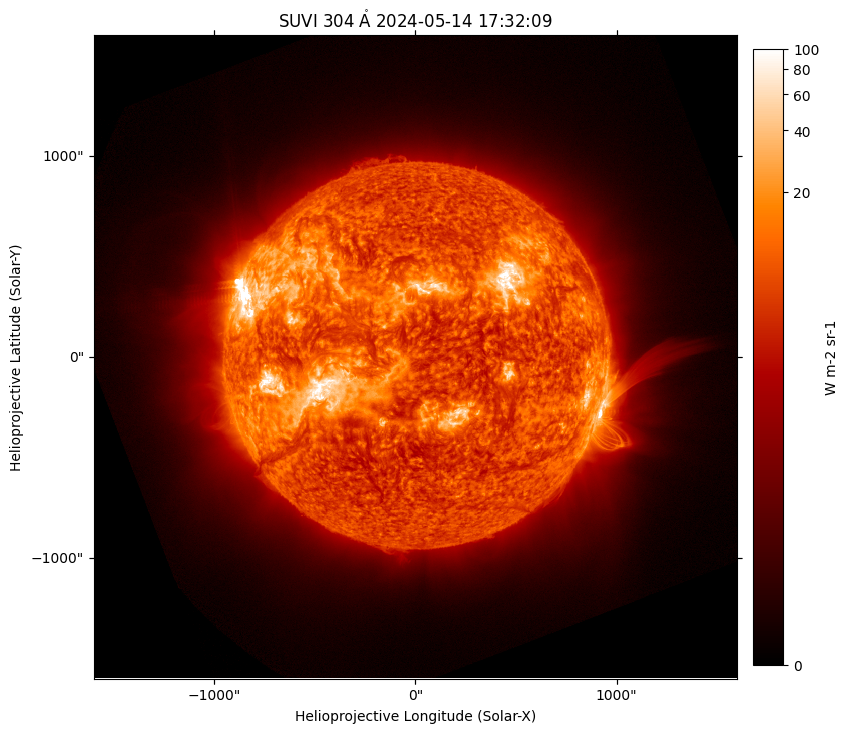

In [21]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=suvi_map)
img = suvi_map.plot(axes=ax)
ax.grid(False)
fig.colorbar(img, shrink=0.8, pad=0.02, label=suvi_map.meta['bunit'])
plt.show()

In [22]:
top_right = SkyCoord(1550*u.arcsec, 150*u.arcsec, frame=suvi_map.coordinate_frame)
bottom_left = SkyCoord(800*u.arcsec, -550*u.arcsec, frame=suvi_map.coordinate_frame)

suvi_submap = suvi_map.submap(bottom_left, top_right=top_right)
rotated_map = suvi_submap.rotate(90*u.deg)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


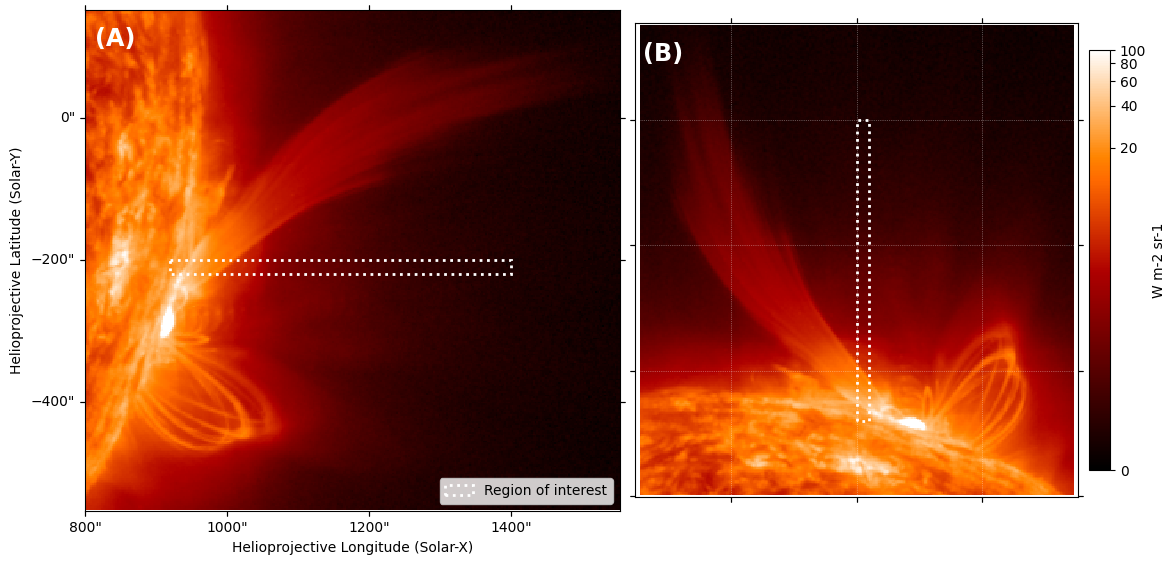

In [23]:
fig = plt.figure(figsize=[12,6])

# Original Map
ax = fig.add_subplot(121, projection=suvi_submap)
suvi_submap.plot(axes=ax)
ax.grid(False)
ax.text(5, suvi_submap.data.shape[1]-40, '(A)', fontdict={'fontsize':'xx-large', 'fontweight':'bold'}, color='white')

coords = SkyCoord(
    Tx=(920, 1400)*u.arcsec,
    Ty=(-200, -220)*u.arcsec,
    frame=suvi_submap.coordinate_frame,
)
suvi_submap.draw_quadrangle(
    coords,
    axes=ax,
    edgecolor='white',
    linestyle=':',
    linewidth=2,
    label='Region of interest'
)
ax.legend(loc='lower right')
ax.set_title('')

# Rotated Map
ax = fig.add_subplot(122, projection=rotated_map)
img = rotated_map.plot(axes=ax)
ax.text(5, rotated_map.data.shape[1]-5, '(B)', fontdict={'fontsize':'xx-large', 'fontweight':'bold'}, color='white')

coords = SkyCoord(
    Tx=(920, 1400)*u.arcsec,
    Ty=(-200, -220)*u.arcsec,
    frame=rotated_map.coordinate_frame,
)
rotated_map.draw_quadrangle(
    coords,
    axes=ax,
    edgecolor='white',
    linestyle=':',
    linewidth=2,
    label='Region of interest'
)
ax.set_title('')

fig.colorbar(img, shrink=0.8, pad=0.02, label=suvi_submap.meta['bunit'])
fig.tight_layout()
plt.show()

In [36]:
suvi_submap.data.shape

(282, 301)

In [ ]:
# define the slit coordinates
slit_coords = SkyCoord(
    Tx=(900, 1100)*u.arcsec,
    Ty=(-360, -480)*u.arcsec,
    frame=suvi_submap.coordinate_frame)

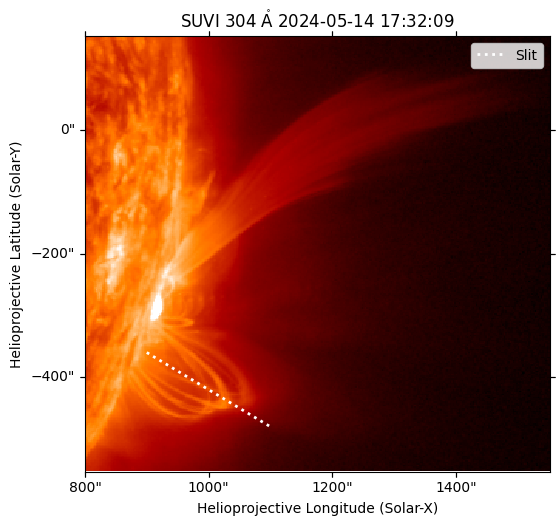

In [83]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection=suvi_submap)
suvi_submap.plot(axes=ax)
ax.plot_coord(slit_coords, color='white', linestyle=':', linewidth=2, label='Slit')
ax.grid(False)
ax.legend()
plt.show()

In [131]:
# obtain the coordinates of the map pixels that intersect that path
intensity_coords = sunpy.map.pixelate_coord_path(suvi_submap, slit_coords)

# pass those coordinates to extract the values for those map pixels
intensity = sunpy.map.sample_at_coords(suvi_submap, intensity_coords)

# calculate the angular separation between the first point and every other coordinate we extracted
angular_separation = intensity_coords.separation(intensity_coords[0]).to(u.arcsec)

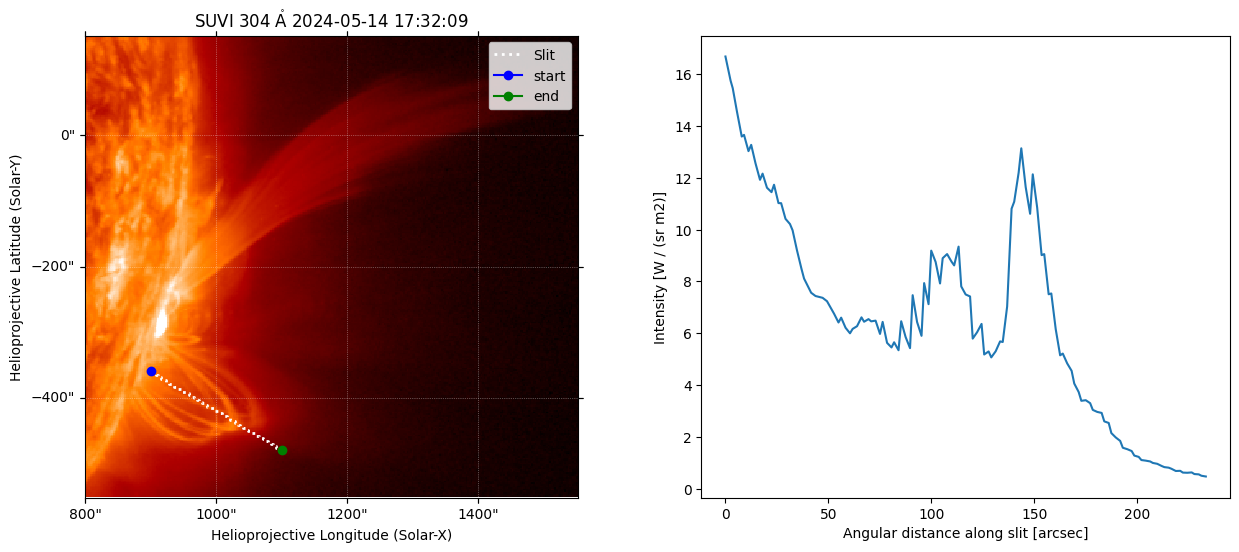

In [136]:
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(121, projection=suvi_submap)
suvi_submap.plot(axes=ax)
ax.plot_coord(intensity_coords, color='white', linestyle=':', linewidth=2, label='Slit')
ax.plot_coord(slit_coords[0], marker='o', color='blue', label='start')
ax.plot_coord(slit_coords[1], marker='o', color='green', label='end')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(angular_separation, intensity)
ax.set_xlabel("Angular distance along slit [arcsec]")
ax.set_ylabel(f'Intensity [{suvi_submap.unit}]')

plt.show()

In [138]:
# validate
d = np.sqrt( (1100 - 900)**2 + (-480 + 360)**2 ) 
d, angular_separation[-1]

(233.23807579381202, <Angle 233.23164741 arcsec>)

In [141]:
# loop over the maps
intensity_values = []
distances = []
times = []

print(f'Total number of files: {len(suvi_fits)}')

for i, m in enumerate(suvi_fits):
    print(f'{i} Working on {m} ..')
    suvi_map = suvi.files_to_map(m, despike_l1b=True)
    
    min_range = 0
    if channel == 94:
        max_range = 20
    elif channel == 171:
        max_range = 20
    elif channel == 131:
        max_range = 20
    elif channel == 195:
        max_range = 50
    elif channel == 284:
        max_range = 50
    elif channel == 304:
        max_range = 100
    
    suvi_map.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
    
    # obtain the coordinates of the map pixels that intersect that path
    intensity_coords = sunpy.map.pixelate_coord_path(suvi_submap, slit_coords)
    # pass those coordinates to extract the values for those map pixels
    intensity = sunpy.map.sample_at_coords(suvi_submap, intensity_coords)
    # calculate the angular separation between the first point and every other coordinate we extracted
    angular_separation = intensity_coords.separation(intensity_coords[0]).to(u.arcsec)
    # append the values to the lists
    intensity_values.append(intensity)
    distances.append(angular_separation)
    times.append(suvi_map.date)

# Convert lists to numpy arrays
intensity_values = np.array(intensity_values)
distances = np.array(distances)
times = np.array(times)

0 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T000000Z_e20240514T000400Z_v1-0-2.fits ..
1 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T000400Z_e20240514T000800Z_v1-0-2.fits ..
2 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T000800Z_e20240514T001200Z_v1-0-2.fits ..
3 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T001200Z_e20240514T001600Z_v1-0-2.fits ..
4 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T001600Z_e20240514T002000Z_v1-0-2.fits ..
5 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T002000Z_e20240514T002400Z_v1-0-2.fits ..
6 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T002400Z_e20240514T002800Z_v1-0-2.fits ..
7 Working on /home/mnedal/data/SUVI/20240514/304A/dr_suvi-l2-ci304_g18_s20240514T002800Z_e20240514T003200Z_v1-0-2.fits ..
8 Working on /home/mneda

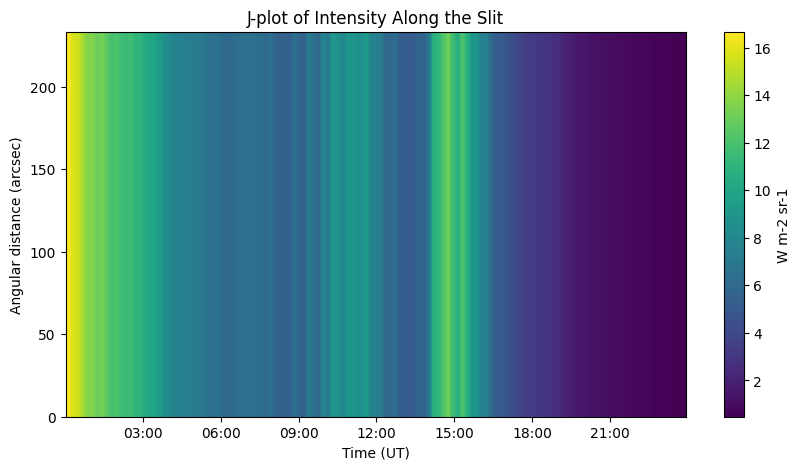

In [193]:
#### Plot the J-plot
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
img = ax.imshow(intensity_values, aspect='auto', origin='lower',
           extent=[mdates.date2num(pd.Timestamp(times[0].value)),
                   mdates.date2num(pd.Timestamp(times[-1].value)),
                   distances[0,:][0],
                   distances[0,:][-1]]
          )
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title('J-plot of Intensity Along the Slit')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img, label=suvi_map.meta['bunit'])
plt.show()

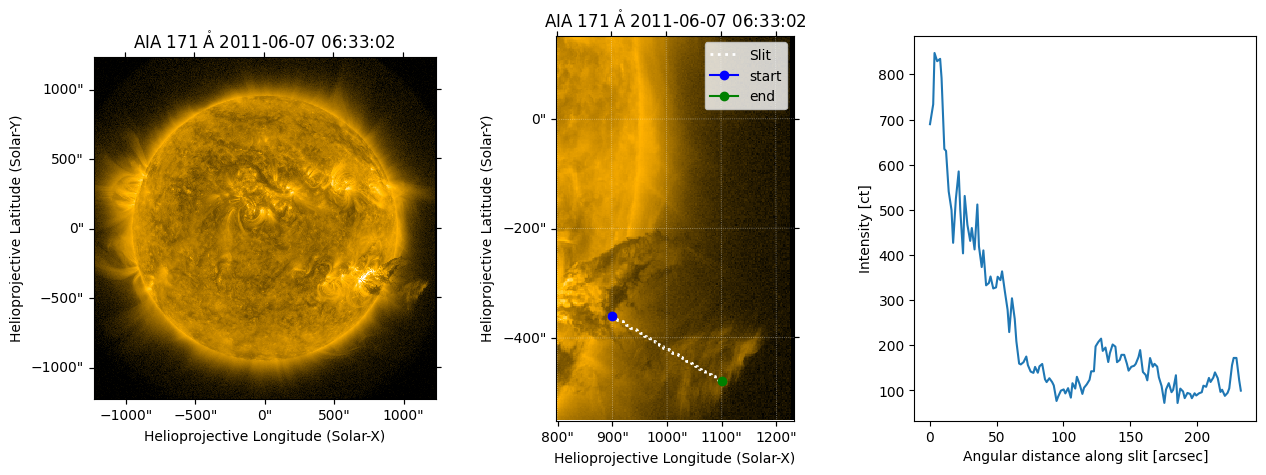

In [29]:
# Test ...

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
import sunpy.data.sample
from astropy.visualization import ImageNormalize, LogStretch

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'


# import the map
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2e4, stretch=LogStretch())

# make a sub-map
top_right = SkyCoord(1550*u.arcsec, 150*u.arcsec, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(800*u.arcsec, -550*u.arcsec, frame=aia_map.coordinate_frame)
aia_submap = aia_map.submap(bottom_left, top_right=top_right)

# define the slit coordinates
slit_coords = SkyCoord(
    Tx=(900, 1100)*u.arcsec,
    Ty=(-360, -480)*u.arcsec,
    frame=aia_map.coordinate_frame)

# obtain the coordinates of the map pixels that intersect that path
intensity_coords = sunpy.map.pixelate_coord_path(aia_submap, slit_coords)

# pass those coordinates to extract the values for those map pixels
intensity = sunpy.map.sample_at_coords(aia_submap, intensity_coords)

# calculate the angular separation between the first point and every other coordinate we extracted
angular_separation = intensity_coords.separation(intensity_coords[0]).to(u.arcsec)

# make a plot
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(131, projection=aia_map)
aia_map.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(132, projection=aia_submap)
aia_submap.plot(axes=ax)
ax.plot_coord(intensity_coords, color='white', linestyle=':', linewidth=2, label='Slit')
ax.plot_coord(slit_coords[0], marker='o', color='blue', label='start')
ax.plot_coord(slit_coords[1], marker='o', color='green', label='end')
ax.legend()

ax = fig.add_subplot(133)
ax.plot(angular_separation, intensity)
ax.set_xlabel("Angular distance along slit [arcsec]")
ax.set_ylabel(f'Intensity [{aia_submap.unit}]')

plt.show()